Note: using 7b for now since 72b doesnt fit in Colab.

In [ ]:
# prompt: Get CUDA if available

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")


CUDA is available. Using device: NVIDIA L4


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="cuda"
)
print(f"using device: {model.device}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

using device: cuda:0


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
prompt = "Can you tell me how to move the sleeping snorlax blocking the road in pokemon firered?"
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
response

"Certainly! In Pokémon FireRed, if you encounter a Snorlax that is sleeping and blocking your path, you can follow these steps to deal with it:\n\n1. **Check for Items**: Before trying anything, make sure you have any items that might help. The most useful items are:\n   - **Revive**: This will wake up the Snorlax, but it will fall asleep again after a few turns.\n   - **Elixir**: This will fully restore the Snorlax's HP and wake it up permanently.\n\n2. **Use Revive or Elixir**:\n   - If you have a Revive, use it on the Snorlax. This will wake it up, but it may fall asleep again after a few turns.\n   - If you have an Elixir, use it on the Snorlax. This will fully restore its HP and wake it up permanently, allowing you to continue your journey.\n\n3. **If No Items Are Available**:\n   - If you don't have either item, you'll need to find another way around the Snorlax. Look for:\n     - **Hidden Machines (HM)**: These are hidden in certain areas and can be used to open doors or walls, 

It doent seem to know much about Pokemon video games, you just need a Poke Flute to wake it up...

# DeepSpeed and QLoRA exploration:

This will be important for synchronizing weight training across GPUs and speeding up our training process on our (relatively) limited resources.

https://github.com/QwenLM/Qwen/blob/main/recipes/finetune/deepspeed/finetune_qlora_multi_gpu.ipynb

https://github.com/deepspeedai/DeepSpeed

https://arxiv.org/abs/2305.14314




Need DeepSpeed JSON file:
```
{
  "zero_optimization": {
    "stage": 2,
    "offload_optimizer": {
      "device": "cpu"
    }
  }
}
```

Some examples here: https://github.com/QwenLM/Qwen/blob/main/finetune/ds_config_zero3.json


# Dataloader and fomatter:
We will need all of our training data in a single JSON. Qwen's finetuning script only accepts a single JSON file.

```
{
    "image": "demo/COCO_train2014_000000580957.jpg",
    "conversations": [
        {
            "from": "human",
            "value": "<image>\nLocate house in this image and output the bbox coordinates in JSON format."
        },
        {
            "from": "gpt",
            "value": "{\n"bbox_2d": [135, 114, 1016, 672]\n}"
        }
    ]
}
```

Install training data from Google Drive:

https://drive.usercontent.google.com/download?id=1_VvhpOiTMLcj9zc7NU1L_nH73PZwYI98&export=download&authuser=1

In [ ]:
!pip install gdown
!mkdir /content/data/

import gdown

id = "1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR"
output = "/content/"
gdown.download(id=id, output=output)

!tar -xvf /content/data-4-29.tar -C /content/data/
!find /content/data/ -type f -name '._*' -delete


Downloading...
From (original): https://drive.google.com/uc?id=1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR
From (redirected): https://drive.google.com/uc?id=1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR&confirm=t&uuid=3016a414-2f36-4b4a-b8c1-a07df5f3f5cd
To: /content/data-4-29.tar
100%|██████████| 113M/113M [00:01<00:00, 82.8MB/s]


._.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./
./._annotations_with_features_and_depth
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations_with_features_and_depth/
./._depth
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./depth/
./._images
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./images/
./._annotations
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations/
./annotations/._20250416_120444_324.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations/20250416_120444_324.json
./annotations/._20250416_115221_557.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations/20250416_115221_557.json
./annotations/._20250416_120421_872.json
tar: Ignoring unknown extended header ke

# Remove feature vector from JSONs

In [ ]:
# prompt: A JSON file has a field "detections" which has a list with subfield called "feature_vector" for each element in the list. remove the feature_vector from the JSON and display the result. Also remove the fields : "timestamp", "image_path", "depth_path". Then save to a new file in the directory /content/data/annotation_depth

import json
import os

def modify_json(json_file_path, output_dir):
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {json_file_path}")
        return

    if "detections" in data and isinstance(data["detections"], list):
        for detection in data["detections"]:
            if "feature_vector" in detection:
                del detection["feature_vector"]

    fields_to_remove = ["timestamp", "image_path", "depth_path", "robot_pose"]
    for field in fields_to_remove:
        if field in data:
            del data[field]

    # Extract filename without extension
    filename = os.path.splitext(os.path.basename(json_file_path))[0]
    output_path = os.path.join(output_dir, f"{filename}.json")

    os.makedirs(output_dir, exist_ok=True)

    with open(output_path, 'w') as outfile:
        json.dump(data, outfile, indent=2)
    print(f"Modified JSON saved to: {output_path}")

# Example usage
# Iterate through all JSON files in the directory
for filename in os.listdir("/content/data/annotations_with_features_and_depth"):
    if filename.endswith(".json"):
        json_filepath = os.path.join("/content/data/annotations_with_features_and_depth", filename)
        modify_json(json_filepath, "/content/data/annotation_depth")


Modified JSON saved to: /content/data/annotation_depth/20250416_120356_268.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120307_584.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120034_268.json
Modified JSON saved to: /content/data/annotation_depth/20250416_115149_506.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120756_891.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120931_044.json
Modified JSON saved to: /content/data/annotation_depth/20250416_121050_997.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120038_650.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120253_052.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120624_769.json
Modified JSON saved to: /content/data/annotation_depth/20250416_120418_177.json
Modified JSON saved to: /content/data/annotation_depth/20250416_115153_101.json
Modified JSON saved to: /content/data/an

In [ ]:
import os
import json

def generate_vlm_prompt(file_path):


  with open(file_path, 'r') as file:
      data = json.load(file)

      # Extract relevant information
      detections = data.get('detections', [])
      image_path = data.get('image_path', 'unknown image path')
      robot_pose = data.get('robot_pose', {})

      # Handle cases where robot_pose is None
      if robot_pose is None:
          translation = {"x": 0, "y": 0, "z": 0}
          orientation = {"x": 0, "y": 0, "z": 0, "w": 0}
      else:
          translation = robot_pose.get('translation', {"x": 0, "y": 0, "z": 0})
          orientation = robot_pose.get('orientation', {"x": 0, "y": 0, "z": 0, "w": 0})

      # Generate prompt parts for detections
      prompt_parts = []
      for detection in detections:
          obj_class = detection.get('class', 'unknown object')
          confidence = detection.get('confidence', 0)
          bbox = detection.get('bbox', {})
          center_x = bbox.get('center_x', 0)
          center_y = bbox.get('center_y', 0)
          size_x = bbox.get('size_x', 0)
          size_y = bbox.get('size_y', 0)
          median_depth = detection.get('median_depth', 'unknown depth')
          feature_vector = detection.get('feature_vector', [])
          feature_vector_str = ', '.join(f"{v:.2f}" for v in feature_vector[:5]) + "..." if feature_vector else "no features"
          prompt_parts.append(
              f"a {obj_class} with confidence {confidence:.2f} "
              f"that has a bounding box at center ({center_x:.2f}, {center_y:.2f}) "
              f"and size ({size_x:.2f}, {size_y:.2f}),"
              f" median depth of the object is {median_depth}"
          )

      # Combine all parts into a single prompt
      detection_description = ", ".join(prompt_parts) if prompt_parts else "no objects detected"

      prompt = (
          f"In the image, there is the following: {detection_description}. "

      )


  return prompt


annotation_directory = "/content/data/annotations_with_features_and_depth/20250416_114635_532.json"
vlm_prompt = generate_vlm_prompt(annotation_directory)

print(vlm_prompt)

In the image, there is the following: a chair with confidence 0.80 that has a bounding box at center (1143.37, 309.99) and size (384.43, 617.33), median depth of the object is 4.0. 


# Formatting raw data for VLM
Raw data will be concatenated into a single JSON. This process assumes `.jpg` and `.json` files have the same identifier ex: `20250416_114635_532.jpg` and `20250416_114635_532.json`.

Some thoughts: Might be worth it to come up with a unique request for the VLM so it knows when to give us our formatted data when we want it.

For example a request we could make might be something like: "Give me the Dhyan Thakkar JSON representation of the objects in this image."

In [ ]:
import json
import os
!mkdir /content/data/json_test/


def create_json_data(data_pt_id):
    image_path = f"{data_pt_id}.jpg"
    # Since JSON doesnt match image names rn:
    # Replace with this line for final deployment
    annotation_path = f"/content/data/annotation_depth/{data_pt_id}.json"

    try:
      with open(annotation_path, "r") as f:
          json_result = json.load(f)
          nat_lang_result = generate_vlm_prompt(annotation_path)
      # Create the JSON data
      json_data = {
          "id": data_pt_id,
          "image": image_path,
          "conversations": [
              {
                  "from": "human",
                  "value": "<image>\nLocate key objects in this image, give a bounding box and median depth for each object."
              },
              {
                  "from": "gpt",
                  "value": f"{nat_lang_result}"
              }
          ]
      }
      return json_data
    except FileNotFoundError:
      print(f"File not found: {data_pt_id}")
      return None


def save_json_to_file(data, filepath):
    with open(filepath, "w") as f:
        json.dump(data, f, indent=4)

# example usage:
data_id = "20250416_114313_135"
json_list = []
json_data = create_json_data(data_id)
json_list.append(json_data)
data_id = "20250416_114315_056"
json_data = create_json_data(data_id)
json_list.append(json_data)
save_json_to_file(json_list, f"/content/data/json_test/{data_id}.json")


mkdir: cannot create directory ‘/content/data/json_test/’: File exists
File not found: 20250416_114313_135
File not found: 20250416_114315_056


In [ ]:
import os

json_list = []
for filename in os.listdir('/content/data/images'):
    if filename.endswith('.jpg'):
        image_id = filename[:-4]  # Remove the .jpg extension
        json_data = create_json_data(image_id)
        if json_data is not None:
          json_list.append(json_data)

save_json_to_file(json_list, "/content/data/json_test/all_data.json")


File not found: 20250416_114447_172
File not found: 20250416_114432_306
File not found: 20250416_114315_056
File not found: 20250416_114436_597
File not found: 20250416_114458_686
File not found: 20250416_114433_447
File not found: 20250416_114628_355
File not found: 20250416_114507_122
File not found: 20250416_114541_679
File not found: 20250416_114627_219
File not found: 20250416_114313_135
File not found: 20250416_114523_546
File not found: 20250416_114551_048
File not found: 20250416_114454_975
File not found: 20250416_114621_925
File not found: 20250416_114428_579
File not found: 20250416_114629_359
File not found: 20250416_114457_647
File not found: 20250416_114554_142
File not found: 20250416_114522_390
File not found: 20250416_114549_107
File not found: 20250416_114512_031
File not found: 20250416_114619_103
File not found: 20250416_114634_329
File not found: 20250416_114445_097
File not found: 20250416_114446_107
File not found: 20250416_114540_530
File not found: 20250416_114

In [ ]:
# prompt: randomly split json_list into a 90% 10% train and validation respectively

import random
import json

def split_json_list(json_list, train_ratio=0.9):
  random.seed(42)
  random.shuffle(json_list)
  split_index = int(len(json_list) * train_ratio)
  train_data = json_list[:split_index]
  validation_data = json_list[split_index:]
  print(len(train_data))
  print(len(validation_data))
  return train_data, validation_data

# Load the JSON data from the file
with open("/content/data/json_test/all_data.json", "r") as f:
    json_list = json.load(f)

# Split the JSON list
train_data, validation_data = split_json_list(json_list)

# Save the train and validation data to separate JSON files
with open("/content/data/json_test/train_data.json", "w") as f:
    json.dump(train_data, f, indent=4)

with open("/content/data/json_test/validation_data.json", "w") as f:
    json.dump(validation_data, f, indent=4)


270
31


In [ ]:
# prompt: Iterate through a JSON with the following format
#     {
#         "id": "20250416_120659_877",
#         "image": "20250416_120659_877.jpg",
#         "conversations": [
#             {
#                 "from": "human",
#                 "value": "<image>\nLocate key objects and display depth and bounding box info in JSON format."
#             },
#             {
#                 "from": "gpt",
#                 "value": "{'detections': [], 'robot_pose': {'translation': {'x': 8.334592944038473, 'y': 0.7319520629242142, 'z': 0.010000000000000002}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.7223127827467604, 'w': 0.6915665144298352}}}"
#             }
#         ]
#     },
#     {
#         "id": "20250416_115134_496",
#         "image": "20250416_115134_496.jpg",
#         "conversations": [
#             {
#                 "from": "human",
#                 "value": "<image>\nLocate key objects and display depth and bounding box info in JSON format."
#             },
#             {
#                 "from": "gpt",
#                 "value": "{'detections': [{'class': 'refrigerator', 'confidence': 0.5175970792770386, 'bbox': {'center_x': 823.1923828125, 'center_y': 451.79241943359375, 'size_x': 197.89593505859375, 'size_y': 226.61474609375}, 'median_depth': 15.0}], 'robot_pose': {'translation': {'x': 0.771111299629785, 'y': 1.4845074402279332, 'z': 0.009999999999999998}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': -0.24842211897318436, 'w': 0.9686518728650004}}}"
#             }
#         ]
#     }
# And get each image name

import json

def get_image_names(json_file_path):
    try:
        with open(json_file_path, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at {json_file_path}")
        return []

    image_names = []
    if isinstance(data, list):
        for item in data:
            if "image" in item:
                image_names.append(item["image"])
    elif isinstance(data, dict):
        if "image" in data:
            image_names.append(data["image"])

    return image_names

# Example usage (assuming your JSON data is in 'all_data.json')
image_names = get_image_names('/content/data/json_test/validation_data.json')
image_names


Error: File not found at /content/data/json_test/validation_data.json


[]

# Bash script outline:


1. Download training JSON (formed ahead of time here, then uploaded to Google drive folder where it can be downloaded)
3. Clone [Qwen Git Repo](https://github.com/QwenLM/Qwen-VL/blob/master/finetune/finetune_qlora_ds.sh)
4.   Run `finetune_qlora_ds.sh`
5.



In [ ]:
#!/bin/bash

#SBATCH --time=24:00:00
#SBATCH --ntasks=8
#SBATCH --mem=1000g
#SBATCH --tmp=1000g
#SBATCH --mail-type=BEGIN,END,FAIL
#SBATCH --mail-user=rajal038@umn.edu
#SBATCH --gres=gpu:h100:2

# Download images/JSON files:
!pip install gdown
!mkdir data

!gdown 1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR -O /content/data/

!tar -xvf data/data-4-29.tar -C data
!find data/data-4-29/ -type f -name '._*' -delete
!rm data-4-29.tar

# Clone Qwen-VL
!git clone https://github.com/QwenLM/Qwen-VL.git
!pip install -r Qwen-VL/requirements.txt
!pip install git+https://github.com/huggingface/transformers.git

!pip install deepspeed
!pip install peft==0.10.0
!pip install optimum
# !pip install gptqmodel
!pip install auto-gptq






mkdir: cannot create directory ‘data’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR
From (redirected): https://drive.google.com/uc?id=1bDRQl0oFcgEjpeMuxu_QCna1qsGnGAaR&confirm=t&uuid=cc554584-342c-4e60-b910-017c2684d564
To: /content/data/data-4-29.tar
100% 113M/113M [00:00<00:00, 170MB/s]
._.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./
./._annotations_with_features_and_depth
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations_with_features_and_depth/
./._depth
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./depth/
./._images
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./images/
./._annotations
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./annotations/
./annotations/._20250416_120444_324.json
tar: Ignoring unkn

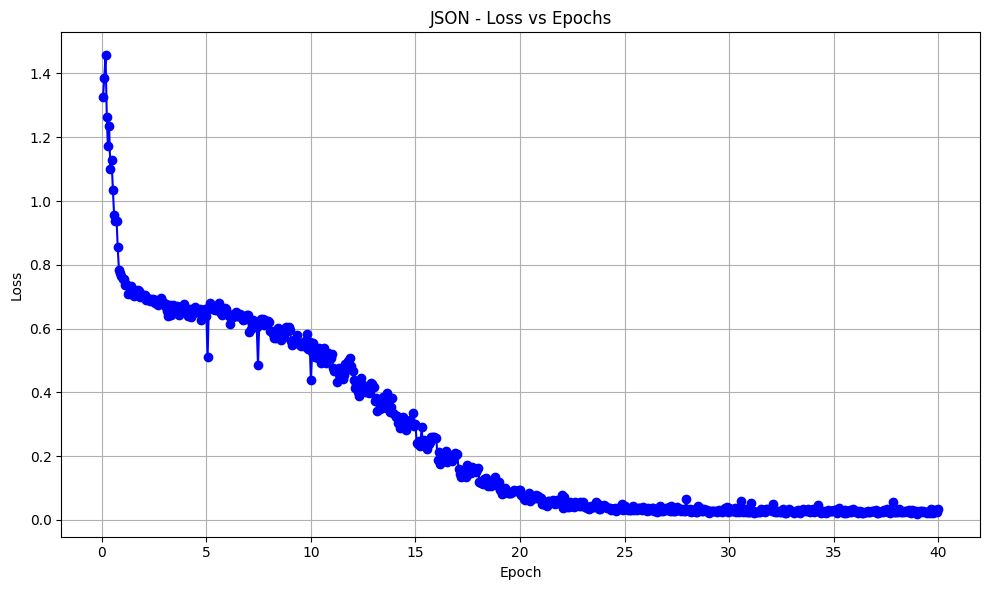

In [10]:
# Re-import necessary libraries due to state reset
import re
import matplotlib.pyplot as plt

# Reload the file
file_path = "/content/json_epochs.txt"
with open(file_path, "r") as file:
    content = file.read()

# Re-apply the regex to extract loss and epoch values
matches = re.findall(r"\{'loss': ([\d.]+), .*? 'epoch': ([\d.]+)\}", content)
losses = [float(match[0]) for match in matches]
epochs = [float(match[1]) for match in matches]

# Regenerate the plot with updated title
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title("JSON - Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()
